In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
import math
import pandas as pd
import random
%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
g = torch.Generator().manual_seed(47)
random.seed(47)
np.random.seed(47)

In [189]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=24, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=24, shuffle=True)


In [228]:
class Conv2d(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel: tuple[int] | int, 
        stride: tuple[int] | int, 
        dilation: int=1, 
        bias: bool=True,
        padding: bool=False
    ) -> None:
        super().__init__()
        kernel = (kernel, kernel) if type(kernel) is int else kernel
        stride = (stride, stride) if type(stride) is int else stride                                   
        
        k = math.sqrt((1 / (in_channels * kernel[0] * kernel[1]))) # interval for optimal initialization
        
        weight_tensor = torch.randn((out_channels, in_channels * kernel[0] * kernel[1])).uniform_(-k, k)
        self.kernel = nn.Parameter(weight_tensor, requires_grad=True).to(device)
        
        bias_tensor = torch.randn((out_channels,)).uniform_(-k, k)
        self.bias = nn.Parameter(bias_tensor, requires_grad=True).to(device) if bias is True else 0
        
        self.out_channels = out_channels
        self.dilation = dilation
        self.kernel_i, self.kernel_j = kernel
        self.stride_i, self.stride_j = stride
        self.padding = padding
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        if self.padding:
            pad_size_i = self.divide_pad(self.kernel.shape[0] - 1)
            pad_size_j = self.divide_pad(self.kernel.shape[1] - 1)
            x = F.pad(x, (*pad_size_j, *pad_size_i))

        B, C, I, J = x.shape # Batch, Channels, I dim, J dim
        
        # strides
        external_b, external_c, internal_i, internal_j = x.stride()
        
        # external stides (the stride outside the kernel)
        external_stride = external_b, self.stride_i * internal_i, self.stride_j * internal_j, external_c
        
        # output image dimensions
        out_i = math.floor(((I - self.dilation * (self.kernel_i - 1) - 1) / self.stride_i) + 1)
        out_j = math.floor(((J - self.dilation * (self.kernel_j - 1) - 1) / self.stride_j) + 1)
                
        shape = (B, C, out_i, out_j, self.kernel_i, self.kernel_j)
        stride = (*external_stride, internal_i * self.dilation, internal_j * self.dilation)
        windows = x.as_strided(size=shape, stride=stride).reshape(B, out_i, out_j, C * self.kernel_i * self.kernel_j)
        
        output = ((windows @ self.kernel.T) + self.bias).transpose(1, -1).transpose(2, -1)

        return output
    
    def divide_pad(self, num):
        quotient = num // 2 
        remainder = num % 2 
        return [quotient, quotient + remainder]


In [229]:
a = torch.tensor(3).float()
b = torch.tensor(6).float()

r = torch.randn(3,500).uniform_(a,b*2)
r

tensor([[10.4159, 11.9170,  6.0893,  ...,  4.5746, 11.6242,  6.6360],
        [ 5.5047, 11.2884,  8.1878,  ...,  5.3853, 10.4238,  8.0188],
        [ 4.3715,  9.1507,  3.4786,  ..., 11.1010, 11.4270,  5.9584]])

In [230]:
class ConvNet(nn.Module):
    def __init__(self, input_dim, fan_in, fan_out, kernel_dim, stride, hidden_dim, output_dim, dilation=1):
        super().__init__()
        self.convo1 = nn.Conv2d(fan_in, fan_out, kernel_dim, stride)
        self.convo2 = nn.Conv2d(fan_out, 5, kernel_dim, stride)
        #print(input_dim, dilation, kernel_dim, stride)
        convo_output_dim = math.floor(((input_dim[0] - dilation * (kernel_dim - 1) - 1) / stride) + 1)
        convo_out2 = math.floor(((convo_output_dim - dilation * (5 - 1) - 1) / stride) + 1)
        
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)
        self.linear1 = nn.Linear(convo_out2**2 * 5, hidden_dim, bias=True)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, y=None, infering=False):
        start = self.convo1(x)
        #print(start.shape)
        x = self.convo2(start)
        #print(x.shape)
        #print(start.shape)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        logits = self.linear2(x) * 0.1
        
        if not infering:
            #print(y.shape)
            #print(logits.shape)
            loss = F.cross_entropy(logits, y)
            return logits, loss
        return logits, _


In [231]:
fan_in = 1
fan_out = 32
input_dim = (28,28)
kernel_dim = 5
stride = 1
hidden_dim = 128
n_filters = 16
output_dim = 10

In [232]:
model = ConvNet(input_dim, fan_in, fan_out, kernel_dim, stride, hidden_dim, output_dim = 10)
model = model.to(device);

In [233]:
opt = torch.optim.AdamW(model.parameters(), lr=0.0001)
loss_tensor = torch.zeros(len(trainloader))
for i, sample in enumerate(trainloader):
    xb = sample[0].squeeze(0).to(device)
    yb = sample[1].squeeze(0).to(device)
    #print(xb.shape, yb.shape)
    logits, loss = model(xb, yb)
    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()
    loss_tensor[i] = loss
    if i == 0:
        print(f'loss {loss.item():.6f}')
        
print('training completed\n')

loss 2.301924
training completed



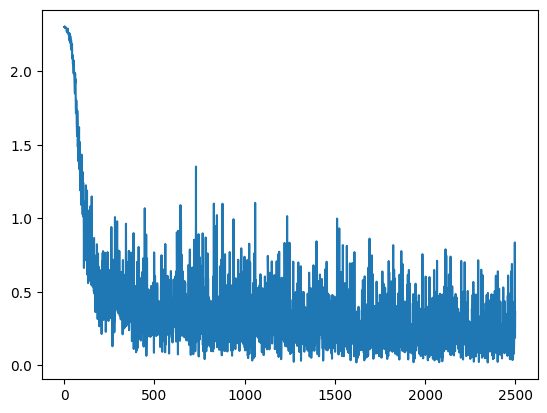

In [234]:
plt.plot(range(len(trainloader)), loss_tensor.tolist())

In [56]:
@torch.no_grad()
def estimate_loss(eval_iters):
    # estimate the loss. the higher eval_iters is, the more precise the loss will be
    print('estimating loss...')
    model.eval()
    correct = 0
    losses = torch.zeros(eval_iters + 1)
    for i, item in enumerate(testloader):
        if i == eval_iters:
            break
        #print(len(item[0]))
        xb = item[0].squeeze(0).to(device)
        yb = item[1].squeeze(0).to(device)
        logits, loss = model(xb, yb)
        losses[i] = loss.item()
        correct += torch.sum((yb == logits.argmax(1))).item()
            
        
    out = losses.mean().item()
    model.train()
    print(f'precision of {correct/(16*eval_iters)}')
    print(correct, 'correct')
    print(f'estimated loss: {out}\n')

In [57]:
estimate_loss(len(testloader))

estimating loss...
torch.Size([512, 10])
torch.Size([512, 10])
torch.Size([512, 10])
torch.Size([512, 10])
torch.Size([512, 10])
torch.Size([512, 10])
torch.Size([512, 10])
torch.Size([512, 10])
torch.Size([512, 10])
torch.Size([512, 10])
torch.Size([512, 10])
torch.Size([512, 10])
torch.Size([512, 10])
torch.Size([512, 10])
torch.Size([512, 10])
torch.Size([512, 10])
torch.Size([512, 10])
torch.Size([512, 10])
torch.Size([512, 10])
torch.Size([272, 10])
precision of 20.715625
6629 correct
estimated loss: 25.639543533325195



In [28]:

len(testloader) + len(trainloader)

138

In [29]:
x = torch.tensor([[
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    [21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    [31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
    [41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
    [51, 52, 53, 54, 55, 56, 57, 58, 59, 60],
    [61, 62, 63, 64, 65, 66, 67, 68, 69, 70],
    [71, 72, 73, 74, 75, 76, 77, 78, 79, 80],
    [81, 82, 83, 84, 85, 86, 87, 88, 89, 90],
    [91, 92, 93, 94, 95, 96, 97, 98, 99, 100],
],
[
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    [21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    [31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
    [41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
    [51, 52, 53, 54, 55, 56, 57, 58, 59, 60],
    [61, 62, 63, 64, 65, 66, 67, 68, 69, 70],
    [71, 72, 73, 74, 75, 76, 77, 78, 79, 80],
    [81, 82, 83, 84, 85, 86, 87, 88, 89, 90],
    [91, 92, 93, 94, 95, 96, 97, 98, 99, 100],
]]).float()
kernel_dim = 3
x.shape

x2 = torch.tensor([
    [1, 2, 3, 4, 5],
    [6, 7, 8, 9, 10],
    [11, 12, 13, 14, 15],
    [16, 17, 18, 19, 20],
    [21, 22, 23, 24, 25],
])

In [30]:
x.stride()

(100, 10, 1)

In [31]:
z = x.as_strided(size=(2, 8, 8, 3, 3), stride=(100, 10, 1, 10, 1))

In [32]:
torch.all(z[0] == z[1])

tensor(True)

In [33]:
x2 = F.pad(x2, (1, 1, 1, 1))
x2

tensor([[ 0,  0,  0,  0,  0,  0,  0],
        [ 0,  1,  2,  3,  4,  5,  0],
        [ 0,  6,  7,  8,  9, 10,  0],
        [ 0, 11, 12, 13, 14, 15,  0],
        [ 0, 16, 17, 18, 19, 20,  0],
        [ 0, 21, 22, 23, 24, 25,  0],
        [ 0,  0,  0,  0,  0,  0,  0]])

In [34]:
x = x.squeeze()

In [35]:
class Conv2ddd(nn.Module):
    def __init__(
        self, 
        stride: tuple[int], 
        kernel: tuple[int], 
        dilation: int=1, 
        bias: bool=True
    ) -> torch.tensor:
        super().__init__()
        self.kernel = nn.Parameter(torch.randn((kernel), generator=g), requires_grad=True).to(device)
        self.dilation = dilation
        self.kernel_i, self.kernel_j = kernel
        self.stride_i, self.stride_j = stride
        #self.bias = nn.Parameter(torch.randn((self.output_dim * self.output_dim), generator=g), requires_grad=True)
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        I, J = x.shape
        
        # internal strides (the stride inside the kernel, which is affected by dilation)
        internal_i, internal_j = x.stride()
        
        # external stides (the stride outside the kernel)
        external_stride = self.stride_i * internal_i, self.stride_j * internal_j 
        
        # output image dimensions
        out_i = int(round((1 + I - self.kernel_i - ((self.kernel_i - 1) * (self.dilation - 1))) / self.stride_i, 0))
        out_j = int(round((1 + J - self.kernel_j - ((self.kernel_j - 1) * (self.dilation - 1))) / self.stride_j, 0))
                
        shape = (out_i, out_j, self.kernel_i, self.kernel_j)
        stride = (*external_stride, internal_i * self.dilation, internal_j * self.dilation)
        windows = x.as_strided(size=shape, stride=stride).reshape(out_i, out_j, -1)

        output = windows @ self.kernel.view(-1)

        return output

In [36]:
class Conv2Dd(nn.Module):
    def __init__(
        self, 
        stride: tuple[int], 
        kernel: tuple[int], 
        dilation: int=1, 
        bias: bool=True,
        padding: bool=False
    ) -> torch.tensor:
        super().__init__()
        self.kernel = nn.Parameter(torch.randn((kernel), generator=g), requires_grad=True)
        self.dilation = dilation
        self.kernel_i, self.kernel_j = kernel
        self.stride_i, self.stride_j = stride
        self.padding = padding
        #self.bias = nn.Parameter(torch.randn((self.output_dim * self.output_dim), generator=g), requires_grad=True)
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        if self.padding:
            I, J = x.shape
            out_i = int(round((1 + I - self.kernel_i - ((self.kernel_i - 1) * (self.dilation - 1))) / self.stride_i, 0))
            out_j = int(round((1 + J - self.kernel_j - ((self.kernel_j - 1) * (self.dilation - 1))) / self.stride_j, 0))
            
            if [out_i, out_j] != [*x.shape]:
                pad_size_i = self.divide_pad(self.kernel.shape[0] - 1)
                pad_size_j = self.divide_pad(self.kernel.shape[1] - 1)
                x = F.pad(x, (*pad_size_j, *pad_size_i))

        I, J = x.shape
        
        # internal strides (the stride inside the kernel, which is affected by dilation)
        internal_i, internal_j = x.stride()
        
        # external stides (the stride outside the kernel)
        external_stride = self.stride_i * internal_i, self.stride_j * internal_j 
        
        # output image dimensions
        out_i = int(round((1 + I - self.kernel_i - ((self.kernel_i - 1) * (self.dilation - 1))) / self.stride_i, 0))
        out_j = int(round((1 + J - self.kernel_j - ((self.kernel_j - 1) * (self.dilation - 1))) / self.stride_j, 0))
                
        shape = (out_i, out_j, self.kernel_i, self.kernel_j)
        stride = (*external_stride, internal_i * self.dilation, internal_j * self.dilation)
        windows = x.as_strided(size=shape, stride=stride).reshape(out_i, out_j, -1)

        output = windows @ self.kernel.view(-1)

        return output  
    
    def divide_pad(self, num):
        quotient = num // 2  # integer division, equivalent to math.floor(num/2)
        remainder = num % 2  # modulo operation, equivalent to num - 2*quotient
        return [quotient, quotient + remainder]


In [37]:
class Conv2d(nn.Module):
    def __init__(
        self, 
        stride: tuple[int], 
        kernel: tuple[int], 
        dilation: int=1, 
        bias: bool=True,
        padding: bool=False
    ) -> torch.tensor:
        super().__init__()
        self.kernel = nn.Parameter(torch.randn((kernel), generator=g), requires_grad=True).to(device)
        self.dilation = dilation
        self.kernel_i, self.kernel_j = kernel
        self.stride_i, self.stride_j = stride
        self.padding = padding
        self.bias = nn.Parameter(torch.zeros((1,)), requires_grad=True).to(device) if bias is True else 0
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        if self.padding:
            pad_size_i = self.divide_pad(self.kernel.shape[0] - 1)
            pad_size_j = self.divide_pad(self.kernel.shape[1] - 1)
            x = F.pad(x, (*pad_size_j, *pad_size_i))

        I, J = x.shape
        
        # internal strides (the stride inside the kernel, which is affected by dilation)
        internal_i, internal_j = x.stride()
        
        # external stides (the stride outside the kernel)
        external_stride = self.stride_i * internal_i, self.stride_j * internal_j 
        
        # output image dimensions
        out_i = int(round((1 + I - self.kernel_i - ((self.kernel_i - 1) * (self.dilation - 1))) / self.stride_i, 0))
        out_j = int(round((1 + J - self.kernel_j - ((self.kernel_j - 1) * (self.dilation - 1))) / self.stride_j, 0))
                
        shape = (out_i, out_j, self.kernel_i, self.kernel_j)
        stride = (*external_stride, internal_i * self.dilation, internal_j * self.dilation)
        windows = x.as_strided(size=shape, stride=stride).reshape(out_i, out_j, -1)

        output = (windows @ self.kernel.view(-1)) + self.bias

        return output  
    
    def divide_pad(self, num):
        quotient = num // 2 
        remainder = num % 2 
        return [quotient, quotient + remainder]


In [38]:
a = torch.randn((10,10,3))

In [39]:
r = torch.tensor([
    [[[1, 2, 3 ], [4, 5, 6 ], [7, 8, 9 ], [10,11,12], [13,14,15], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3]],
    [[16,17,18], [19,20,21], [22,23,24], [25,26,27], [28,29,30], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3]],
    [[31,32,33], [34,35,36], [37,38,39], [40,41,42], [43,44,45], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3]],
    [[46,47,48], [49,50,51], [52,53,54], [55,56,57], [58,59,60], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3]],
    [[61,62,63], [64,65,66], [67,68,69], [70,71,72], [73,74,75], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3]],
    [[1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3]],
    [[1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3]],
    [[1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3]],
    [[1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3]],
    [[1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3]]],
    
    [[[1, 2, 3 ], [4, 5, 6 ], [7, 8, 9 ], [10,11,12], [13,14,15], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3]],
    [[16,17,18], [19,20,21], [22,23,24], [25,26,27], [28,29,30], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3]],
    [[31,32,33], [34,35,36], [37,38,39], [40,41,42], [43,44,45], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3]],
    [[46,47,48], [49,50,51], [52,53,54], [55,56,57], [58,59,60], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3]],
    [[61,62,63], [64,65,66], [67,68,69], [70,71,72], [73,74,75], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3]],
    [[1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3]],
    [[1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3]],
    [[1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3]],
    [[1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3]],
    [[1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3], [1,2,3]],]
])
r.shape




torch.Size([2, 10, 10, 3])

In [40]:
class Conv2d1(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel: tuple[int] | int, 
        stride: tuple[int] | int, 
        dilation: int=1, 
        bias: bool=True,
        padding: bool=False
    ) -> torch.tensor:
        super().__init__()
        kernel = (kernel, kernel) if type(kernel) is int else kernel
        stride = (stride, stride) if type(stride) is int else stride
        weight_tensor = torch.randn((out_channels, in_channels * kernel[0] * kernel[1]), generator=g)
        self.kernel = nn.Parameter(weight_tensor, requires_grad=True).to(device)
        self.bias = nn.Parameter(torch.zeros((out_channels,)), requires_grad=True).to(device) if bias is True else 0
        self.out_channels = out_channels
        self.dilation = dilation
        self.kernel_i, self.kernel_j = kernel
        self.stride_i, self.stride_j = stride
        self.padding = padding
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        if self.padding:
            pad_size_i = self.divide_pad(self.kernel.shape[0] - 1)
            pad_size_j = self.divide_pad(self.kernel.shape[1] - 1)
            x = F.pad(x, (*pad_size_j, *pad_size_i))

        B, C, I, J = x.shape # Batch, Channels, I dim, J dim
        
        # strides
        external_b, external_c, internal_i, internal_j = x.stride()
        
        # external stides (the stride outside the kernel)
        external_stride = external_b, external_c, self.stride_i * internal_i, self.stride_j * internal_j 
        
        # output image dimensions
        out_i = math.floor(((I - self.dilation * (self.kernel_i - 1) - 1) / self.stride_i) + 1)
        out_j = math.floor(((J - self.dilation * (self.kernel_j - 1) - 1) / self.stride_j) + 1)
                
        shape = (B, C, out_i, out_j, self.kernel_i, self.kernel_j)
        stride = (*external_stride, internal_i * self.dilation, internal_j * self.dilation)

        windows = x.as_strided(size=shape, stride=stride).reshape(B, out_i, out_j, C * self.kernel_i * self.kernel_j)
        
        
        output = ((windows @ self.kernel.T) + self.bias).transpose(1, 1)

        return output
    
    def divide_pad(self, num):
        quotient = num // 2 
        remainder = num % 2 
        return [quotient, quotient + remainder]


In [41]:
#Output Height = ((Input Height + (2 * Padding) - ((Kernel Height - 1) * Dilation + 1)) / Stride) + 1
math.floor(((50 - 20 * (5 - 1) - 1) / self.stride_i) + 1)
out_i

NameError: name 'self' is not defined

In [ ]:
cv =    Conv2d1(3,4,kernel=3,stride=15, dilation=20)
cv2 = nn.Conv2d(3,4,kernel_size=3,stride=15, dilation=20)

In [ ]:
k = 5
s = 5
d = 2
cv =    Conv2d1(3,4,kernel=k,stride=s, dilation=d)
cv2 = nn.Conv2d(3,4,kernel_size=k,stride=s, dilation=d)

In [ ]:
inpt = torch.randn((12,3,50,50)).to(device)
s1 = cv(inpt).shape
s2 = cv2(inpt.to('cpu')).shape

print(s1, s2)

In [16]:
img = torch.tensor([
    [[2, 1, 10, 1],
    [6, 1, 1, 1],
    [1, 1, 1, 1],
    [1, 1, 1, 0]],
    
    [[3,3,11,3],
     [3,3,4,3],
     [3,3,3,3],
     [3,3,3,8]],
    
    [[2,2,12,2],
     [2,2,2,2],
    [2,2,2,2],
   [2,2,2,9]]
])
print(img.stride())
r = img.as_strided(size=(3, 16), stride=(16,1)).as_strided(size=(4,4,3), stride=(4, 1, 16))
print(r)
print(r.stride())

print(r.as_strided(size=(3,3), stride=(1,16)))

(16, 4, 1)
tensor([[[ 2,  3,  2],
         [ 1,  3,  2],
         [10, 11, 12],
         [ 1,  3,  2]],

        [[ 6,  3,  2],
         [ 1,  3,  2],
         [ 1,  4,  2],
         [ 1,  3,  2]],

        [[ 1,  3,  2],
         [ 1,  3,  2],
         [ 1,  3,  2],
         [ 1,  3,  2]],

        [[ 1,  3,  2],
         [ 1,  3,  2],
         [ 1,  3,  2],
         [ 0,  8,  9]]])
(4, 1, 16)
tensor([[ 2,  3,  2],
        [ 1,  3,  2],
        [10, 11, 12]])


In [17]:
t = nn.Conv2d(3, 1, 2, 1)
t(torch.randn(3,3,3)).shapedd

AttributeError: 'Tensor' object has no attribute 'shapedd'

In [176]:
inp2 = torch.tensor([[
    [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
 [31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
 [41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
 [51, 52, 53, 54, 55, 56, 57, 58, 59, 60],
 [61, 62, 63, 64, 65, 66, 67, 68, 69, 70],
 [71, 72, 73, 74, 75, 76, 77, 78, 79, 80],
 [81, 82, 83, 84, 85, 86, 87, 88, 89, 90],
 [91, 92, 93, 94, 95, 96, 97, 98, 99, 100],
 [91, 92, 93, 94, 95, 96, 97, 98, 99, 100]],
 [[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10],
 [-11, -12, -13, -14, -15, -16, -17, -18, -19, -20],
 [-21, -22, -23, -24, -25, -26, -27, -28, -29, -30],
 [-31, -32, -33, -34, -35, -36, -37, -38, -39, -40],
 [-41, -42, -43, -44, -45, -46, -47, -48, -49, -50],
 [-51, -52, -53, -54, -55, -56, -57, -58, -59, -60],
 [-61, -62, -63, -64, -65, -66, -67, -68, -69, -70],
 [-71, -72, -73, -74, -75, -76, -77, -78, -79, -80],
 [-81, -82, -83, -84, -85, -86, -87, -88, -89, -90],
[-91, -92, -93, -94, -95, -96, -97, -98, -99, -100],
 [-91, -92, -93, -94, -95, -96, -97, -98, -99, -100]],
    [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
],
[
    [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
 [31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
 [41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
 [51, 52, 53, 54, 55, 56, 57, 58, 59, 60],
 [61, 62, 63, 64, 65, 66, 67, 68, 69, 70],
 [71, 72, 73, 74, 75, 76, 77, 78, 79, 80],
 [81, 82, 83, 84, 85, 86, 87, 88, 89, 90],
 [91, 92, 93, 94, 95, 96, 97, 98, 99, 100],
[91, 92, 93, 94, 95, 96, 97, 98, 99, 100]],
 [[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10],
 [-11, -12, -13, -14, -15, -16, -17, -18, -19, -20],
 [-21, -22, -23, -24, -25, -26, -27, -28, -29, -30],
 [-31, -32, -33, -34, -35, -36, -37, -38, -39, -40],
 [-41, -42, -43, -44, -45, -46, -47, -48, -49, -50],
 [-51, -52, -53, -54, -55, -56, -57, -58, -59, -60],
 [-61, -62, -63, -64, -65, -66, -67, -68, -69, -70],
 [-71, -72, -73, -74, -75, -76, -77, -78, -79, -80],
 [-81, -82, -83, -84, -85, -86, -87, -88, -89, -90],
  [-91, -92, -93, -94, -95, -96, -97, -98, -99, -100],
 [-91, -92, -93, -94, -95, -96, -97, -98, -99, -100]],
    [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]]
]]
)
inp2.shape

torch.Size([2, 3, 11, 10])

In [177]:
ker2 = torch.tensor([
    
    [
        
    [[2, 2, 2, 2, 2],
     [2, 2, 2, 2, 2],
     [2, 2, 2, 2, 2],
     [2, 2, 2, 2, 2],
     [2, 2, 2, 2, 2],
    ],
    [[10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10],
    ],
    [[3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3],]
    
    ],
    
    [
        
    [[2, 2, 2, 2, 2],
     [2, 2, 2, 2, 2],
     [2, 2, 2, 2, 2],
     [2, 2, 2, 2, 2],
     [2, 2, 2, 2, 2],
    ],
    [[10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10],
    ],
    [[3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3]]

    ],
    
    [
        
    [[0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0]],
    [[0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0]],
    [[0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0]],

    ],
    [
        
    [[2, 2, 2, 2, 2],
     [2, 2, 2, 2, 2],
     [2, 2, 2, 2, 2],
     [2, 2, 2, 2, 2],
     [2, 2, 2, 2, 2],
    ],
    [[10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10],
    [10, 10, 10, 10, 10],
    ],
    [[3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3],
    [3, 3, 3, 3, 3]]

    ],
    [[[1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1]],
 [[1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1]],
 [[2, 2, 2, 2, 2],
  [2, 2, 2, 2, 2],
  [1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1]]]

])

In [178]:
r = torch.randn((1, 3, 11, 10))
p = nn.Conv2d(3, 1, kernel_size=5, stride=1)

p(r).shape

torch.Size([1, 1, 7, 6])

In [179]:
inp2.stride()

(330, 110, 10, 1)

In [180]:

wind = inp2.as_strided(stride=(330, 10, 1, 110, 10, 1), size=(2,7,6,3,5,5)).float()
ker2 = ker2.float()


In [181]:
(wind.reshape(2, 7, 6, -1) @ ker2.view(5, -1).T).transpose(-1, 1).transpose(2, -1)


tensor([[[[ -4525.,  -4725.,  -4925.,  -5125.,  -5325.,  -5525.],
          [ -6525.,  -6725.,  -6925.,  -7125.,  -7325.,  -7525.],
          [ -8525.,  -8725.,  -8925.,  -9125.,  -9325.,  -9525.],
          [-10525., -10725., -10925., -11125., -11325., -11525.],
          [-12525., -12725., -12925., -13125., -13325., -13525.],
          [-14525., -14725., -14925., -15125., -15325., -15525.],
          [-16125., -16325., -16525., -16725., -16925., -17125.]],

         [[ -4525.,  -4725.,  -4925.,  -5125.,  -5325.,  -5525.],
          [ -6525.,  -6725.,  -6925.,  -7125.,  -7325.,  -7525.],
          [ -8525.,  -8725.,  -8925.,  -9125.,  -9325.,  -9525.],
          [-10525., -10725., -10925., -11125., -11325., -11525.],
          [-12525., -12725., -12925., -13125., -13325., -13525.],
          [-14525., -14725., -14925., -15125., -15325., -15525.],
          [-16125., -16325., -16525., -16725., -16925., -17125.]],

         [[     0.,      0.,      0.,      0.,      0.,      0.],
      

In [98]:
ker2.view(5, 75) @ wind[0][0][0].reshape(75,-1)

tensor([[-545.],
        [-545.],
        [   0.],
        [-545.],
        [-235.]])

In [ ]:
print(wind.shape, ker2.shape)

In [ ]:
win = torch.tensor([[
    [
    [1,2,3],
    [4,5,6],
    [7,8,9]
    ],
    [
    [1,2,3],
    [4,5,6],
    [7,8,9]
    ],
    [
    [10,10,10],
    [10,10,10],
    [10,10,10],
    ]
],
    [
    [
   [10,10,10],
    [10,10,10],
    [10,10,10],
    ],
    [
  [10,10,10],
    [10,10,10],
    [10,10,10],
    ],
    [
    [10,10,10],
    [10,10,10],
    [10,10,10],
    ]
],]
    
    
)

k = torch.tensor([[
    [[1,1,1],
    [2,2,2],
    [3,3,3]],
    
    [[0,0,0],
    [1,1,1],
    [100,100,100]],

    [
    [-100, -100, -100],
    [-100, -100, -100],
    [-100, -100, -100],
    ],
],
    [[[1,1,1],
    [2,2,2],
    [3,3,3]],
    
    [[0,0,0],
    [1,1,1],
    [100,100,100]],

    [
    [-100, -100, -100],
    [-100, -100, -100],
    [-100, -100, -100],
    ]],
     [[[1,1,1],
    [2,2,2],
    [3,3,3]],
    
    [[0,0,0],
    [1,1,1],
    [100,100,100]],

    [
    [-100, -100, -100],
    [-100, -100, -100],
    [-100, -100, -100],
    ]]
])

In [ ]:
win.view(2, -1) 
    

In [ ]:
(win.view(2, -1) @ k.view(3, -1).T)

In [ ]:
(ker2.view(4, 75) @ wind.reshape(75, -1, 2) )

In [ ]:
class Conv2d(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel: tuple[int] | int, 
        stride: tuple[int] | int, 
        dilation: int=1, 
        bias: bool=True,
        padding: bool=False
    ) -> None:
        super().__init__()
        kernel = (kernel, kernel) if type(kernel) is int else kernel
        stride = (stride, stride) if type(stride) is int else stride                                   
        
        k = math.sqrt((1 / (in_channels * kernel[0] * kernel[1]))) # interval for optimal initialization
        
        weight_tensor = torch.randn((out_channels, in_channels * kernel[0] * kernel[1]), generator=g).uniform_(-k, k)
        self.kernel = nn.Parameter(weight_tensor, requires_grad=True).to(device)
        
        bias_tensor = torch.randn((out_channels,)).uniform_(-k, k)
        self.bias = nn.Parameter(bias_tensor, requires_grad=True).to(device) if bias is True else 0
        
        self.out_channels = out_channels
        self.dilation = dilation
        self.kernel_i, self.kernel_j = kernel
        self.stride_i, self.stride_j = stride
        self.padding = padding
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        if self.padding:
            pad_size_i = self.divide_pad(self.kernel.shape[0] - 1)
            pad_size_j = self.divide_pad(self.kernel.shape[1] - 1)
            x = F.pad(x, (*pad_size_j, *pad_size_i))

        B, C, I, J = x.shape # Batch, Channels, I dim, J dim
        
        # strides
        external_b, external_c, internal_i, internal_j = x.stride()
        
        # external stides (the stride outside the kernel)
        external_stride = external_b, external_c, self.stride_i * internal_i, self.stride_j * internal_j 
        
        # output image dimensions
        out_i = math.floor(((I - self.dilation * (self.kernel_i - 1) - 1) / self.stride_i) + 1)
        out_j = math.floor(((J - self.dilation * (self.kernel_j - 1) - 1) / self.stride_j) + 1)
                
        shape = (B, C, out_i, out_j, self.kernel_i, self.kernel_j)
        stride = (*external_stride, internal_i * self.dilation, internal_j * self.dilation)

        windows = x.as_strided(size=shape, stride=stride).reshape(B, out_i, out_j, C * self.kernel_i * self.kernel_j)
        
        
        output = ((windows @ self.kernel.T) + self.bias).transpose(1, -1).transpose(2, -1)

        return output
    
    def divide_pad(self, num):
        quotient = num // 2 
        remainder = num % 2 
        return [quotient, quotient + remainder]
